In [1]:
# univariate multi-step lstm
import time
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
import numpy as np
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from scipy.stats import pearsonr
import keras
import pydotplus as pydot
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot



pred = []
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train,test, n_input)
	#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)     
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	#print(predictions)    
	#print(len(predictions))
	#print(test[:, :, 0])    
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	# plot history
	#pyplot.plot(history.history['loss'], label='train')
	#pyplot.plot(history.history['val_loss'], label='test')
	#pyplot.legend()
	#pyplot.show()
	#pyplot.plot(test)
	#pyplot.plot(predictions)
	#pyplot.show()
	return score, scores , test[:, :, 0] , predictions

In [2]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	#print(actual[0:,1] , predicted[0:,1])    
	scores = list()
	#corcff = list()
	#print(scores)
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		#r = np.corrcoef(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
		#corcff.append(r)        
	# calculate overall RMSE
	#corcff.append(r)
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores


In [3]:
# summarize scores
def summarize_scores(name, score, scores):
	summary = []    
	s_scores = ', '.join(['%.1f' % s for s in scores])
	#for i in range(0,5,1):
		#summary.append(float((s_scores[i]+s_scores[i+5]))/2.0)                
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [4]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=5):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	#print(data)  
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [5]:
# train the model
from keras.utils.vis_utils import plot_model
def build_model(train,test, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	test_X , test_y = to_supervised(test, n_input)   
	# define parameters
	verbose, epochs, batch_size = 0, 80, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
  #model.add(Dense(50, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam' ,metrics=['accuracy'])
	plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
	#plot_model(model, show_shapes=True, show_layer_names=True)
	print(model.summary())
	# fit network
	history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,validation_data=(test_X, test_y) , verbose = verbose)
	#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
	print(history.history.keys())
	# summarize history for accuracy
	pyplot.plot(history.history['accuracy'])
	pyplot.plot(history.history['val_accuracy'])
	pyplot.title('model accuracy')
	pyplot.ylabel('accuracy')
	pyplot.xlabel('epoch')
	#pyplot.axis([0, 50, [.125,0.2,0.3]])
	pyplot.legend(['train', 'test'], loc='upper left')
	pyplot.show()
	# summarize history for loss
	pyplot.plot(history.history['loss'], label=['Training'])
	pyplot.plot(history.history['val_loss'] , label=['Validation'])
	pyplot.title('model loss')
	pyplot.ylabel('loss')
	pyplot.xlabel('epoch')
	pyplot.legend(['train', 'test'], loc='upper left')
	pyplot.show()

	return model

In [6]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	pred = yhat
	#predict.append(yhat)
	return yhat

In [7]:
# split into standard weeks
from numpy import split
from numpy import array
from pandas import read_csv
from pandas import to_numeric
from datetime import datetime

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[0:-260], data[-260:]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/5))
	test = array(split(test, len(test)/5))
	return train, test

In [8]:
import pandas as pd
import numpy as np
import io
from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean
# load the new file
#dataset = read_csv((io.BytesIO(uploaded['NIFTY_lstm.csv'])), header=0, index_col=['Date'])
dataset = read_csv("E:/Univariate_N5/NIFTY_lstm.csv", header=0, index_col=['Date'])
dataset.info()
print(dataset)
#for i in range(len(dataset1)):
    #dataset1.at[i,'Date'] = datetime.strptime(dataset1.at[i,'Date'], "%d-%b-%y")
    #dataset1.at[i,'Date'] = dataset1.at[i,'Date'].strftime('%Y-%m-%d')
#dataset1.to_csv("Replica.csv")
#dataset = read_csv('Replica.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
#dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]
# validate train data
train, test = split_dataset(dataset.values)
print(train.shape, 'train')
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape, 'val')
print(test[0, 0, 0], test[-1, -1, 0])

<class 'pandas.core.frame.DataFrame'>
Index: 2870 entries, 29-Dec-08 to 27-Dec-19
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2870 non-null   float64
 1   Open    2870 non-null   float64
 2   High    2870 non-null   float64
 3   Low     2870 non-null   float64
dtypes: float64(4)
memory usage: 112.1+ KB
              Close      Open      High       Low
Date                                             
29-Dec-08   2146.55   2121.40   2155.70   2066.70
30-Dec-08   2197.55   2147.70   2207.70   2138.30
31-Dec-08   2187.00   2215.60   2222.65   2170.00
01-Jan-09   2280.15   2201.95   2285.60   2197.05
02-Jan-09   2262.80   2287.45   2304.00   2255.15
...             ...       ...       ...       ...
23-Dec-19  15865.50  15811.40  15936.00  15809.05
24-Dec-19  15778.20  15877.40  15880.15  15739.45
25-Dec-19  15778.20  15877.40  15880.15  15739.45
26-Dec-19  15706.45  15784.45  15806.85  15690.95
27-Dec-19  15780.70  

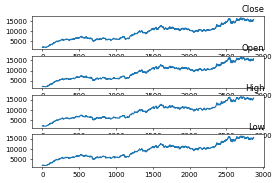

In [9]:
values = dataset.values
#specify the columns to plot
groups = [0,1,2,3]
i=1
pyplot.figure(dpi = 50)
for group in groups:
	pyplot.subplot(len(groups),1,i)
	pyplot.plot(values[:, group])
  #pyplot.subplots_adjust(bottom= 0.2, top= 0.2)
	pyplot.title(dataset.columns[group], y=1, loc='right')
	i += 1
pyplot.show()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 182,205
Trainable params: 182,205
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


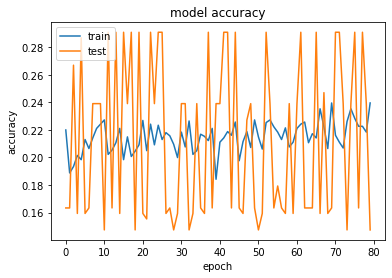

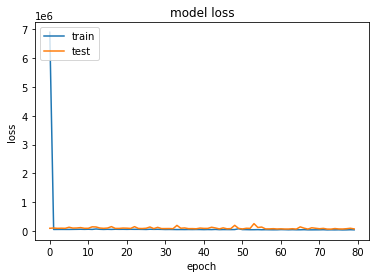

Time Taken
131.55241441726685


In [10]:
start = time.time()
n_input = 5
score, scores , actual , pred= evaluate_model(train, test, n_input)
# summarize scores
end = time.time()
print("Time Taken")
print(end - start)

lstm: [276.450] 269.7, 275.0, 243.8, 277.5, 311.9


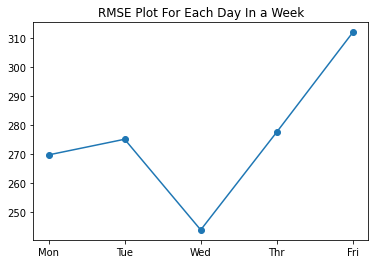

In [11]:
summarize_scores('lstm', score, scores)
# plot scores
days = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri']
pyplot.plot(days, scores, marker='o', label='LSTM')
pyplot.title("RMSE Plot For Each Day In a Week")
pyplot.show()

#print("Prediction")
#print(pred)
pred = np.reshape(pred,260)

In [12]:
actual = dataset[-260:]['Close']
actual = array(split(actual , len(actual)/10))
print(actual.shape)
actual = np.reshape(actual,260)
#print(actual.shape)
print("The Actual Values")
print(actual)
#print(len(actual))
#pred = np.reshape(pred,260)
#print(len(pred))
print("The Predicted Values")
print(pred)
rmse = sqrt(mean_squared_error(actual, pred))
rmse_by_mean = rmse/(mean(actual))
print("RMSE/Mean : %.5f" % rmse_by_mean)
corr, _ = pearsonr(actual, pred)
print('Pearsons correlation: %.3f' % corr)


(26, 10)
The Actual Values
[14440.3  14450.9  14447.1  14322.15 14146.15 14291.5  14285.7  14326.05
 14323.25 14307.1  14223.6  14658.5  14707.8  14800.25 14892.95 14966.4
 14962.6  14888.75 14971.85 15039.25 15120.1  15231.3  15255.2  15499.3
 15724.3  15754.8  15738.7  16055.6  16085.85 16019.8  16099.05 15938.6
 16041.65 15861.65 15815.6  15659.   15333.5  15609.45 15588.9  15684.7
 16003.7  15989.6  15902.1  15732.   15848.3  15848.3  15664.1  15735.05
 15582.1  15408.7  15388.5  15384.55 15342.9  15260.45 15546.6  15359.45
 15495.55 15599.25 15599.25 15551.1  15416.85 15356.6  15339.4  15566.75
 15628.2  15840.65 15988.4  15962.95 15744.8  15923.05 16028.25 16121.6
 15999.15 15874.75 15911.1  16113.7  16084.9  16084.9  16079.3  16079.3
 16150.6  16166.3  16370.35 16352.75 16504.45 16504.45 16705.4  16705.4
 16403.7  16092.9  16111.35 16135.75 16061.6  16132.85 15949.6  15955.3
 15762.75 15776.8  15933.95 15843.35 15968.2  15766.95 15666.15 15538.85
 15569.85 15556.65 15762.05 1586

In [13]:
print("The Weekly RMSE:")
print("Mon------------------Tue----------------------Wed-------------------Thu------------------Fri")
print(scores)
week_day = [0,0,0,0,0]
score_week_day = [0,0,0,0,0]
day = 0
actual = np.reshape(actual,(52,5))
#print(actual.shape)
for i in range(5):
    for j in range(52):
        week_day[i] = week_day[i] + actual[j,i]
    week_day[i] = week_day[i]/52
    score_week_day[i] = scores[i]/week_day[i] 

print("The Weekly RMSE/Mean:")
print("Mon------------------Tue----------------------Wed--------------------Thu------------------Fri")
print(score_week_day)    
    


The Weekly RMSE:
Mon------------------Tue----------------------Wed-------------------Thu------------------Fri
[269.6567582324869, 275.0481766539705, 243.84320848008497, 277.5491214265915, 311.8700299013374]
The Weekly RMSE/Mean:
Mon------------------Tue----------------------Wed--------------------Thu------------------Fri
[0.017310183582735155, 0.017678442426276763, 0.015640689598642368, 0.017819408141290873, 0.020025579008227556]


In [15]:
from IPython.display import display,Image
#display(Image(filename = "model_plot.png"))

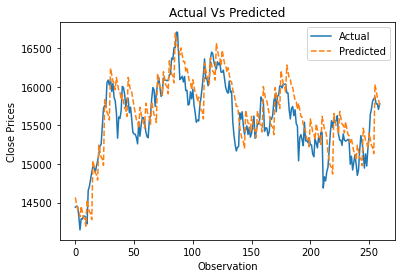

In [16]:
actual = np.reshape(actual,260)
pyplot.title("Actual Vs Predicted")
pyplot.plot(actual , label='Actual')
pyplot.plot(pred , linestyle='dashed' , label='Predicted')
pyplot.legend()
pyplot.xlabel('Observation')
pyplot.ylabel('Close Prices')
pyplot.show()

